In [70]:
!where python
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

C:\Users\gabri\anaconda3\envs\RDP\python.exe
C:\Users\gabri\AppData\Local\Microsoft\WindowsApps\python.exe
CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


Revise el capítulo 2 de "Machine Learning y Deep Learning" de Jesús Bobadilla disponible en: https://elibro.net/es/lc/cayetano/titulos/222698.
Seleccione uno de los datasets (por grupo) y responda las siguientes preguntas:

**1. ¿Con qué finalidad se elaboraron y compartieron estos datos?**

In [71]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from torchvision import datasets, transforms
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm 

In [72]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
mnist_test = datasets.MNIST(root='./data',train=False,download=True,transform=transform)

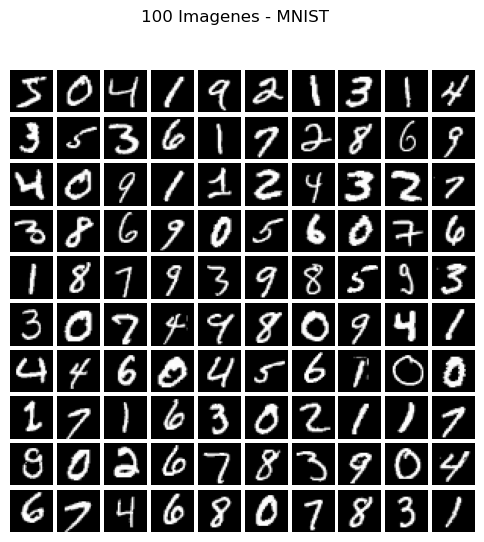

In [73]:
X_train = mnist_train.data.numpy()
Y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
Y_test = mnist_test.targets.numpy()
X = np.concatenate((X_train,X_test),axis=0)
Y = np.concatenate((Y_train,Y_test),axis=0)
fig,axes=plt.subplots(10,10,figsize=(6,6))
fig.subplots_adjust(hspace=0.1,wspace=0.1)

for i,ax in enumerate(axes.flat):
    ax.imshow(X[i],cmap="gray")
    ax.axis("off")
plt.suptitle("100 Imagenes - MNIST", fontsize=12)
plt.show()

**2. ¿Con qué finalidad se elaboraron y compartieron estos datos?**

La base de datos MNIST se creó con el objetivo de ser un benchmark estándar para evaluar modelos de clasificación de imágenes, especialmente en el reconocimiento de dígitos escritos a mano

**3. ¿Que información consideras indispensable para conocer mejor los datos contenidos? (Incorpora todo lo que consideres necesario, como gráficas, fuentes bibliográficas, etc.)**

- Analisis de Elementos Nulos

In [74]:
print("Hay valores NAN en el dataset?: ", np.isnan(X).any())
print("Hay valores negativos=: ",(X<0).any())

Hay valores NAN en el dataset?:  False
Hay valores negativos=:  False


- Analisis de distribución de clases

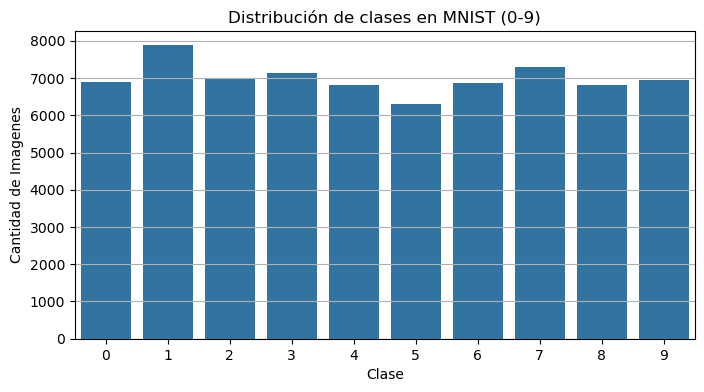

In [75]:
plt.figure(figsize=(8,4))
sns.countplot(x=Y)
plt.title("Distribución de clases en MNIST (0-9)")
plt.xlabel("Clase");plt.ylabel("Cantidad de Imagenes");plt.grid(True,axis="y");plt.show()

- Información de los pixeles

In [76]:
pixels_flat = X.reshape(X.shape[0], -1)
df_stats = pd.DataFrame({
    "Mínimo": [pixels_flat.min()],
    "Máximo": [pixels_flat.max()],
    "Media": [pixels_flat.mean()],
    "Desviación estándar": [pixels_flat.std()],
    "Mediana": [np.median(pixels_flat)],
    "Porcentaje de píxeles cero": [np.sum(pixels_flat == 0) /
pixels_flat.size * 100]
})
print(df_stats.T)

                                0
Mínimo                       0.00
Máximo                     255.00
Media                       33.39
Desviación estándar         78.65
Mediana                      0.00
Porcentaje de píxeles cero  80.86


- Histograma

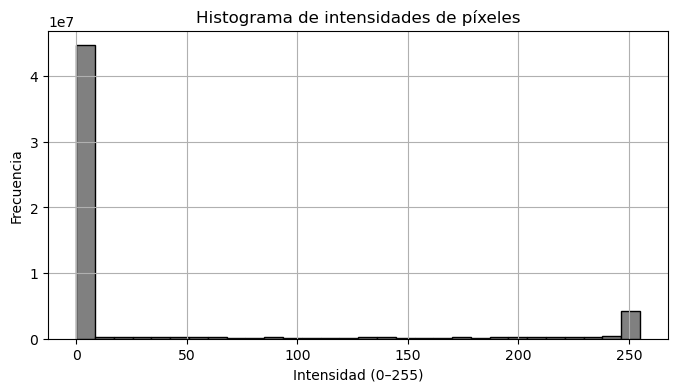

In [77]:
plt.figure(figsize=(8, 4))
plt.hist(pixels_flat.flatten(), bins=30, color='gray', 
edgecolor='black')
plt.title("Histograma de intensidades de píxeles")
plt.xlabel("Intensidad (0–255)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

La mayoría de los píxeles están cerca de 0 (fondo negro), con algunos picos entre 50 y 255 que corresponden a los trazos.

**4. ¿Como aprovecharias esta información en la actualidad?**

| **Propósito**                                 | **Descripción**                                                                 | **Referencia**                   |
|----------------------------------------------|----------------------------------------------------------------------------------|----------------------------------|
| 1. Evaluación de clasificadores              | Benchmark estándar para comparar modelos clásicos y modernos de clasificación. | LeCun et al., 1998               |
| 2. Entrenamiento de CNNs                     | Base para probar arquitecturas convolucionales en reconocimiento visual.        | Cireşan et al., 2012             |
| 3. Enseñanza de ML/DL                        | Ideal para cursos y tutoriales sobre aprendizaje automático y redes neuronales. | Goodfellow et al., 2016          |
| 4. Desarrollo de sistemas OCR                | Utilizado para crear y validar sistemas de reconocimiento óptico de caracteres manuscritos. | Graves et al., 2009              |
| 5. Análisis de generalización                | Evaluación de la robustez de modelos frente a variaciones en los datos.         | Simard et al., 2003              |

**5. ¿Qué modelos han sido empleados en el uso de esta base de datos? ¿Cómo han sido sus métricas?**

| **Modelo**                        | **Descripción breve**                                                             | **Accuracy** | **Referencia**              |
|----------------------------------|----------------------------------------------------------------------------------------------------------|--------------|-----------------------------|
| k-NN (k-Nearest Neighbors)       | Clasificador basado en distancia entre vectores de píxeles. Simple, pero costoso.    | ~96%         | LeCun et al., 1998          |
| SVM (RBF kernel)                 | Separador óptimo con kernel no lineal para patrones complejos.                       | ~98.6%       | Scholkopf et al., 1999      |
| MLP (Perceptrón multicapa)       | Red neuronal totalmente conectada. Rápida pero menos eficiente para imágenes.        | ~98%         | LeCun et al., 1998          |
| LeNet-5 (CNN)                    | Primera red convolucional profunda, especialmente diseñada para dígitos manuscritos. | ~99.2%       | LeCun et al., 1998          |
| Deep CNN moderna                 | Arquitecturas más profundas como ResNet o DropConnect CNN.                           | >99.5%       | Cireşan et al., 2012        |
| Capsule Networks                 | Modelo que captura relaciones espaciales jerárquicas.                                | -            | -                           |

**6. Realiza un screening de modelos de ML para esta base de datos usando Pycaret o Lazypredict ¿Cuál fue tu mejor modelo obtenido?**

In [78]:
X_flat = X.reshape(X.shape[0], -1) # Aplanar imágenes de 28x28 a vectores de 784
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

models_to_try = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("KNN", KNeighborsClassifier())
]

results = []
predictions = {}

for name, model in tqdm(models_to_try, desc="Modelos evaluados"):
    try:
        instance = clone(model)
        start = time.time()
        instance.fit(X_train_split, y_train_split)
        pred = instance.predict(X_test_split)
        end = time.time()
        acc = accuracy_score(y_test_split, pred)
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Train Time (s)': round(end - start, 2)
        })
        predictions[name] = pred
    except Exception as e:
        print(f"[ERROR] Modelo '{name}' falló con error: {e}")
        
df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print("\nScreening de los modelos:")
print(df_results)

Modelos evaluados:   0%|          | 0/3 [00:00<?, ?it/s]


Screening de los modelos:
                 Model  Accuracy  Train Time (s)
0                  KNN      0.97           25.54
1        Random Forest      0.97           61.49
2  Logistic Regression      0.92          129.34


En el screening realizado sobre el dataset MNIST, se evaluaron tres modelos de machine learning: K-Nearest Neighbors (KNN), Random Forest y Regresión Logística. Los resultados muestran que tanto KNN como Random Forest alcanzaron una precisión del 97%, superando a la Regresión Logística, que obtuvo una precisión del 92%. Esto se debe a la mayor capacidad de capturar relaciones no lineales en los datos de KNN y Random Forest. Sin embargo, también es importante considerar otros factores como el tiempo de entrenamiento, la complejidad computacional y la interpretabilidad antes de seleccionar el modelo final.